In [1]:
import pandas as pd
import numpy as np
import os
import glob

# --- CONFIGURATION ---
# Path where your massive time files are stored
DATA_DIR = "/media/hansheng/cc7df9bc-e728-4b8d-a215-b64f31876acc/cdo-tee-mock/prepayment/data/Extracted_data/"
PERF_FILE = DATA_DIR + "combined_performance_history_2017_2020.csv"
ORIG_FILE = DATA_DIR + "combined_sampled_mortgages_2017_2020.csv"
OUTPUT_FILE = DATA_DIR + "mortgage_survival_dataset.csv"


In [2]:


# Updated Columns based on your sample (33 Cols)
TIME_COLS = [
    "LOAN_SEQUENCE_NUMBER", "MONTHLY_REPORTING_PERIOD", "CURRENT_ACTUAL_UPB", 
    "CURRENT_LOAN_DELINQUENCY_STATUS", "LOAN_AGE", "REMAINING_MONTHS_TO_LEGAL_MATURITY", 
    "REPURCHASE_FLAG", "MODIFICATION_FLAG", "ZERO_BALANCE_CODE", 
    "ZERO_BALANCE_EFFECTIVE_DATE", "CURRENT_INTEREST_RATE", "CURRENT_DEFERRED_UPB", 
    "DUE_DATE_OF_LAST_PAID_INSTALLMENT", "MI_RECOVERIES", "NET_SALES_PROCEEDS", 
    "NON_MI_RECOVERIES", "EXPENSES", "LEGAL_COSTS", "MAINTENANCE_AND_PRESERVATION_COSTS", 
    "TAXES_AND_INSURANCE", "MISC_EXPENSES", "ACTUAL_LOSS_CALCULATION", "MODIFICATION_COST", 
    "STEP_MODIFICATION_FLAG", "DEFERRED_PAYMENT_PLAN", "ESTIMATED_LOAN_TO_VALUE", 
    "ZERO_BALANCE_REMOVAL_UPB", "DELINQUENT_ACCRUED_INTEREST", "DELINQUENCY_DUE_TO_DISASTER", 
    "BORROWER_ASSISTANCE_STATUS_CODE", "CURRENT_MONTH_MODIFICATION_COST", "INTEREST_BEARING_UPB", 
    "SOURCE_QUARTER"
]

def get_event_status(group):
    """
    Determines the terminal state of a loan.
    Returns: (Duration, Event_Type)
    Event 0: Censored (Active)
    Event 1: Prepaid
    Event 2: Default
    """
    # 1. Sort by Age to ensure chronological order
    group = group.sort_values("LOAN_AGE")
    last_row = group.iloc[-1]
    
    # 2. Check Terminal State (Zero Balance Code)
    # Handle both string '01' and float 1.0
    zbc = last_row["ZERO_BALANCE_CODE"]
    
    try:
        zbc_float = float(zbc)
    except (ValueError, TypeError):
        zbc_float = 0.0

    # Logic: Prepay (Code 1)
    if zbc_float == 1.0:
        return last_row["LOAN_AGE"], 1
    
    # Logic: Default (Codes 3, 6, 9)
    if zbc_float in [3.0, 6.0, 9.0]:
        return last_row["LOAN_AGE"], 2
        
    # 3. Check Delinquency History (Technical Default)
    # If a loan ever hits 6+ months delinquent (D180), we treat it as a default event
    # even if it cures later (Competing Risk logic).
    # Convert 'R', 'XX', etc to NaN -> 0
    delinq_vals = pd.to_numeric(group["CURRENT_LOAN_DELINQUENCY_STATUS"], errors='coerce').fillna(0)
    
    if (delinq_vals >= 6).any():
        # Duration is the FIRST time it hit D6
        first_def_idx = (delinq_vals >= 6).idxmax()
        duration = group.loc[first_def_idx, "LOAN_AGE"]
        return duration, 2

    # 4. Censored (Still Active)
    return last_row["LOAN_AGE"], 0

def main():
    print("1. Loading Origination Data...")
    df_orig = pd.read_csv(ORIG_FILE, sep='|', low_memory=False)
    
    print("2. Processing Performance Data (Grouping by Loan)...")
    # Reading the large combined file. If this is too large for RAM, use chunking (previous method).
    # Assuming the 6000-loan merged file fits in memory.
    df_perf = pd.read_csv(PERF_FILE, sep='|', names=TIME_COLS, header=0, low_memory=False)
    
    # Filter to ensure we only process the IDs we have originations for
    target_ids = set(df_orig['LOAN_SEQUENCE_NUMBER'])
    df_perf = df_perf[df_perf['LOAN_SEQUENCE_NUMBER'].isin(target_ids)]
    
    # Apply Logic
    print("   Calculating Events...")
    events = df_perf.groupby("LOAN_SEQUENCE_NUMBER").apply(get_event_status)
    
    # Structure into DataFrame
    df_events = pd.DataFrame(events.tolist(), index=events.index, columns=['DURATION', 'EVENT'])
    
    # Merge Covariates
    print("3. Merging Covariates...")
    final_df = df_orig.merge(df_events, left_on='LOAN_SEQUENCE_NUMBER', right_index=True)
    
    final_df.to_csv(OUTPUT_FILE, index=False)
    print(f"Done! Saved {len(final_df)} loans to {OUTPUT_FILE}")

if __name__ == "__main__":
    main()

1. Loading Origination Data...
2. Processing Performance Data (Grouping by Loan)...
   Calculating Events...


/tmp/ipykernel_8433/3388883756.py:75: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  events = df_perf.groupby("LOAN_SEQUENCE_NUMBER").apply(get_event_status)


3. Merging Covariates...
Done! Saved 80000 loans to /media/hansheng/cc7df9bc-e728-4b8d-a215-b64f31876acc/cdo-tee-mock/prepayment/data/Extracted_data/mortgage_survival_dataset.csv


In [3]:
import pandas as pd
import numpy as np

# 1. Define Market Rates (Full dictionary from previous context)
MARKET_RATES = {
    # 2017
    201701: 4.15, 201702: 4.17, 201703: 4.20, 201704: 4.05, 201705: 4.01, 201706: 3.90,
    201707: 3.97, 201708: 3.88, 201709: 3.81, 201710: 3.90, 201711: 3.92, 201712: 3.95,
    # 2018
    201801: 4.03, 201802: 4.33, 201803: 4.44, 201804: 4.47, 201805: 4.59, 201806: 4.57,
    201807: 4.53, 201808: 4.55, 201809: 4.63, 201810: 4.83, 201811: 4.87, 201812: 4.64,
    # 2019
    201901: 4.46, 201902: 4.37, 201903: 4.27, 201904: 4.14, 201905: 4.07, 201906: 3.80,
    201907: 3.77, 201908: 3.62, 201909: 3.61, 201910: 3.69, 201911: 3.70, 201912: 3.72,
    # 2020
    202001: 3.62, 202002: 3.47, 202003: 3.45, 202004: 3.31, 202005: 3.23, 202006: 3.16,
    202007: 3.02, 202008: 2.94, 202009: 2.89, 202010: 2.83, 202011: 2.77, 202012: 2.68,
    # 2021
    202101: 2.74, 202102: 2.81, 202103: 3.08, 202104: 3.06, 202105: 2.96, 202106: 2.98,
    202107: 2.87, 202108: 2.84, 202109: 2.90, 202110: 3.07, 202111: 3.07, 202112: 3.10,
    # 2022
    202201: 3.45, 202202: 3.76, 202203: 4.17, 202204: 4.98, 202205: 5.23, 202206: 5.52,
    202207: 5.41, 202208: 5.22, 202209: 6.11, 202210: 6.90, 202211: 6.76, 202212: 6.35,
    # 2023
    202301: 6.25, 202302: 6.30, 202303: 6.54, 202304: 6.34, 202305: 6.43, 202306: 6.71,
    202307: 6.84, 202308: 7.07, 202309: 7.20, 202310: 7.62, 202311: 7.44, 202312: 6.82,
    # 2024
    202401: 6.64, 202402: 6.78, 202403: 6.82, 202404: 6.99, 202405: 7.06, 202406: 6.92,
    202407: 6.82, 202408: 6.50, 202409: 6.18, 202410: 6.43, 202411: 6.81, 202412: 6.72
}

# 2. Load Data
df = pd.read_csv(DATA_DIR + "mortgage_survival_dataset.csv")

# 3. Feature Engineering Function
def get_incentive_metrics(row):
    try:
        start_date = int(row['FIRST_PAYMENT_DATE'])
        duration = int(row['DURATION'])
        note_rate = row['ORIGINAL_INTEREST_RATE']
        
        start_year = start_date // 100
        start_month = start_date % 100
        
        cumulative_incentive = 0.0
        current_incentive = 0.0
        
        # Limit loop to avoid hanging on bad data, though DURATION should be reasonable
        duration = min(duration, 360) 
        
        for i in range(duration):
            total_months = start_month + i - 1
            curr_year = start_year + (total_months // 12)
            curr_month = (total_months % 12)
            if curr_month == 0:
                curr_month = 12
                curr_year -= 1
            
            yyyymm = (curr_year * 100) + curr_month
            market_rate = MARKET_RATES.get(yyyymm, 4.0)
            
            incentive = note_rate - market_rate
            
            if incentive > 0:
                cumulative_incentive += incentive
            
            if i == duration - 1:
                current_incentive = incentive
                
        return pd.Series([current_incentive, cumulative_incentive])
    except:
        return pd.Series([0.0, 0.0])

# 4. Apply Feature Engineering
print("Processing data...")
metrics = df.apply(get_incentive_metrics, axis=1)
df[['RATE_INCENTIVE', 'BURNOUT_PROXY']] = metrics

# 5. Save Processed Data for User
output_filename = DATA_DIR + "processed_mortgage_data_for_modeling.csv"
df.to_csv(output_filename, index=False)

print(f"Processed data saved to {output_filename}")
print(df[['LOAN_SEQUENCE_NUMBER', 'DURATION', 'EVENT', 'RATE_INCENTIVE', 'BURNOUT_PROXY']].head())

/tmp/ipykernel_8433/3984040502.py:33: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_DIR + "mortgage_survival_dataset.csv")


Processing data...
Processed data saved to /media/hansheng/cc7df9bc-e728-4b8d-a215-b64f31876acc/cdo-tee-mock/prepayment/data/Extracted_data/processed_mortgage_data_for_modeling.csv
  LOAN_SEQUENCE_NUMBER  DURATION  EVENT  RATE_INCENTIVE  BURNOUT_PROXY
0         F17Q10141137        98      0           1.250         100.25
1         F17Q10000777        51      1           1.190          26.28
2         F17Q10240479        98      0           0.000          26.70
3         F17Q10166939        60      1           0.490          37.70
4         F17Q10287022        35      1           0.905          11.40


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# You need to install these: pip install lifelines scikit-survival
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored, integrated_brier_score
from sksurv.util import Surv

# --- CONFIGURATION ---
DATA_FILE = DATA_DIR + "processed_mortgage_data_for_modeling.csv"
TEST_SIZE = 0.25
RANDOM_SEED = 42

def main():
    print("1. Loading Processed Data...")
    df = pd.read_csv(DATA_FILE)
    
    # Define Predictors and Target
    # We use our new features: RATE_INCENTIVE and BURNOUT_PROXY
    features = ['RATE_INCENTIVE', 'BURNOUT_PROXY', 'CREDIT_SCORE', 'ORIGINAL_LTV', 
                'ORIGINAL_DEBT_TO_INCOME_RATIO', 'ORIGINAL_INTEREST_RATE']
    
    target_duration = 'DURATION'
    target_event = 'EVENT' # 0=Censored, 1=Prepay, 2=Default
    
    # Filter: Analysis of Prepayment Risk Only
    # Treat Defaults (2) as Censored (0)
    print("   Setting up Prepayment Target...")
    df['IS_PREPAID'] = df[target_event].apply(lambda x: 1 if x == 1 else 0)
    
    # Drop rows with missing values to prevent model errors
    df_clean = df[features + [target_duration, 'IS_PREPAID']].dropna()
    print(f"   Modeling Universe: {len(df_clean)} loans")

    # 2. Split Data (Train / Test)
    print(f"\n2. Splitting Data ({int(TEST_SIZE*100)}% Hold-out)...")
    train, test = train_test_split(df_clean, test_size=TEST_SIZE, random_state=RANDOM_SEED)
    
    # ---------------------------------------------------------
    # MODEL A: COX PROPORTIONAL HAZARD
    # ---------------------------------------------------------
    print("\n3. Training Cox Proportional Hazard Model...")
    cph = CoxPHFitter()
    try:
        cph.fit(train, duration_col=target_duration, event_col='IS_PREPAID')
        
        # Evaluate C-Index
        cox_pred = cph.predict_partial_hazard(test)
        cox_c_index = concordance_index(test[target_duration], -cox_pred, test['IS_PREPAID'])
        print(f"   -> Cox Model C-Index (Test): {cox_c_index:.4f}")
        
        # Print Coefficients to verify Incentive/Burnout logic
        print("\n   Cox Coefficients:")
        print(cph.params_)
        
    except Exception as e:
        print(f"   Cox Error: {e}")
        cox_c_index = 0

    # ---------------------------------------------------------
    # MODEL B: RANDOM SURVIVAL FOREST (ML)
    # ---------------------------------------------------------
    print("\n4. Training Random Survival Forest (RSF)...")
    
    # Format data for Scikit-Survival
    X_train = train[features]
    X_test = test[features]
    
    # Create structured Target array (Boolean Event, Time)
    y_train_surv = Surv.from_dataframe("IS_PREPAID", target_duration, train)
    y_test_surv = Surv.from_dataframe("IS_PREPAID", target_duration, test)
    
    rsf = RandomSurvivalForest(
        n_estimators=100, 
        min_samples_split=10, 
        min_samples_leaf=15, 
        n_jobs=-1, 
        random_state=RANDOM_SEED
    )
    rsf.fit(X_train, y_train_surv)
    
    # Evaluate C-Index
    rsf_c_index = rsf.score(X_test, y_test_surv)
    print(f"   -> RSF Model C-Index (Test): {rsf_c_index:.4f}")
    
    # Evaluate Integrated Brier Score (IBS) - Accuracy Check
    # We check accuracy at specific time points (e.g. 12, 24, 36 months)
    try:
        times = np.quantile(test[target_duration][test['IS_PREPAID']==1], np.linspace(0.1, 0.9, 10))
        surv_probs = rsf.predict_survival_function(X_test)
        
        # Matrix of probabilities for IBS
        preds = np.row_stack([fn(times) for fn in surv_probs])
        ibs_score = integrated_brier_score(y_train_surv, y_test_surv, preds, times)
        print(f"   -> RSF Integrated Brier Score: {ibs_score:.4f} (Lower is better)")
    except Exception as e:
        print(f"   (IBS Calculation skipped: {e})")
    
    # ---------------------------------------------------------
    # COMPARISON
    # ---------------------------------------------------------
    print("\n" + "="*40)
    print("FINAL MODEL COMPARISON")
    print("="*40)
    print(f"{'Metric':<20} | {'Cox Model':<10} | {'RSF (ML)':<10}")
    print("-" * 40)
    print(f"{'C-Index (Ranking)':<20} | {cox_c_index:.4f}     | {rsf_c_index:.4f}")
    print("-" * 40)
    
    if rsf_c_index > cox_c_index:
        print("\nWinner: Random Survival Forest")
        print("Reasoning: The Prepayment function is likely non-linear (S-Curve).")
    else:
        print("\nWinner: Cox Proportional Hazard")
        print("Reasoning: The relationship is linear and Incentive-driven.")

    return cph, rsf
if __name__ == "__main__":
    cph, rsf = main()

1. Loading Processed Data...


/tmp/ipykernel_8433/651726937.py:20: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_FILE)


   Setting up Prepayment Target...
   Modeling Universe: 80000 loans

2. Splitting Data (25% Hold-out)...

3. Training Cox Proportional Hazard Model...
   -> Cox Model C-Index (Test): 0.8015

   Cox Coefficients:
covariate
RATE_INCENTIVE                   0.151122
BURNOUT_PROXY                   -0.090219
CREDIT_SCORE                     0.000161
ORIGINAL_LTV                    -0.000931
ORIGINAL_DEBT_TO_INCOME_RATIO   -0.000444
ORIGINAL_INTEREST_RATE           2.304980
Name: coef, dtype: float64

4. Training Random Survival Forest (RSF)...
   -> RSF Model C-Index (Test): 0.9064
   -> RSF Integrated Brier Score: 0.0512 (Lower is better)

FINAL MODEL COMPARISON
Metric               | Cox Model  | RSF (ML)  
----------------------------------------
C-Index (Ranking)    | 0.8015     | 0.9064
----------------------------------------

Winner: Random Survival Forest
Reasoning: The Prepayment function is likely non-linear (S-Curve).


In [5]:
import joblib

# ... (After fitting cph and rsf) ...

print("Saving models to disk...")

# 1. Save Cox Model
# Note: Lifelines objects pickle well, but ensure you use the same library version when loading.
joblib.dump(cph, DATA_DIR + "cox_prepayment_model.pkl")

# 2. Save Random Survival Forest
# Scikit-survival objects are scikit-learn compatible.
joblib.dump(rsf, DATA_DIR + "rsf_prepayment_model.pkl")

print("Models saved successfully!")

Saving models to disk...
Models saved successfully!


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# You need to install these: pip install lifelines scikit-survival
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored, integrated_brier_score
from sksurv.util import Surv

# --- CONFIGURATION ---
DATA_FILE = DATA_DIR + "processed_mortgage_data_for_modeling.csv"
TEST_SIZE = 0.25
RANDOM_SEED = 42

def main():
    print("1. Loading Processed Data...")
    df = pd.read_csv(DATA_FILE)
    
    # Define Predictors and Target
    # We use our new features: RATE_INCENTIVE and BURNOUT_PROXY
    features = ['RATE_INCENTIVE', 'BURNOUT_PROXY', 'CREDIT_SCORE', 'ORIGINAL_LTV', 
                'ORIGINAL_DEBT_TO_INCOME_RATIO', 'ORIGINAL_INTEREST_RATE']
    
    target_duration = 'DURATION'
    target_event = 'EVENT' # 0=Censored, 1=Prepay, 2=Default
    
    # Filter: Analysis of Prepayment Risk Only
    # Treat Defaults (2) as Censored (0)
    print("   Setting up Prepayment Target...")
    df['IS_PREPAID'] = df[target_event].apply(lambda x: 1 if x == 1 else 0)
    
    # Drop rows with missing values to prevent model errors
    df_clean = df[features + [target_duration, 'IS_PREPAID']].dropna()
    print(f"   Modeling Universe: {len(df_clean)} loans")

    # 2. Split Data (Train / Test)
    print(f"\n2. Splitting Data ({int(TEST_SIZE*100)}% Hold-out)...")
    train, test = train_test_split(df_clean, test_size=TEST_SIZE, random_state=RANDOM_SEED)
    
    # ---------------------------------------------------------
    # MODEL A: COX PROPORTIONAL HAZARD
    # ---------------------------------------------------------
    print("\n3. Training Cox Proportional Hazard Model...")
    cph = CoxPHFitter()
    try:
        cph.fit(train, duration_col=target_duration, event_col='IS_PREPAID')
        
        # Evaluate C-Index
        cox_pred = cph.predict_partial_hazard(test)
        cox_c_index = concordance_index(test[target_duration], -cox_pred, test['IS_PREPAID'])
        print(f"   -> Cox Model C-Index (Test): {cox_c_index:.4f}")
        
        # Print Coefficients to verify Incentive/Burnout logic
        print("\n   Cox Coefficients:")
        print(cph.params_)
        
    except Exception as e:
        print(f"   Cox Error: {e}")
        cox_c_index = 0

    # ---------------------------------------------------------
    # MODEL B: RANDOM SURVIVAL FOREST (ML)
    # ---------------------------------------------------------
    print("\n4. Training Random Survival Forest (RSF)...")
    
    # Format data for Scikit-Survival
    X_train = train[features]
    X_test = test[features]
    
    # Create structured Target array (Boolean Event, Time)
    y_train_surv = Surv.from_dataframe("IS_PREPAID", target_duration, train)
    y_test_surv = Surv.from_dataframe("IS_PREPAID", target_duration, test)
    
    rsf = RandomSurvivalForest(
        n_estimators=100, 
        min_samples_split=10, 
        min_samples_leaf=15, 
        n_jobs=-1, 
        random_state=RANDOM_SEED
    )
    rsf.fit(X_train, y_train_surv)
    
    # Evaluate C-Index
    rsf_c_index = rsf.score(X_test, y_test_surv)
    print(f"   -> RSF Model C-Index (Test): {rsf_c_index:.4f}")
    
    # Evaluate Integrated Brier Score (IBS) - Accuracy Check
    # We check accuracy at specific time points (e.g. 12, 24, 36 months)
    try:
        times = np.quantile(test[target_duration][test['IS_PREPAID']==1], np.linspace(0.1, 0.9, 10))
        surv_probs = rsf.predict_survival_function(X_test)
        
        # Matrix of probabilities for IBS
        preds = np.row_stack([fn(times) for fn in surv_probs])
        ibs_score = integrated_brier_score(y_train_surv, y_test_surv, preds, times)
        print(f"   -> RSF Integrated Brier Score: {ibs_score:.4f} (Lower is better)")
    except Exception as e:
        print(f"   (IBS Calculation skipped: {e})")
    
    # ---------------------------------------------------------
    # COMPARISON
    # ---------------------------------------------------------
    print("\n" + "="*40)
    print("FINAL MODEL COMPARISON")
    print("="*40)
    print(f"{'Metric':<20} | {'Cox Model':<10} | {'RSF (ML)':<10}")
    print("-" * 40)
    print(f"{'C-Index (Ranking)':<20} | {cox_c_index:.4f}     | {rsf_c_index:.4f}")
    print("-" * 40)
    
    if rsf_c_index > cox_c_index:
        print("\nWinner: Random Survival Forest")
        print("Reasoning: The Prepayment function is likely non-linear (S-Curve).")
    else:
        print("\nWinner: Cox Proportional Hazard")
        print("Reasoning: The relationship is linear and Incentive-driven.")

    return cph, rsf
if __name__ == "__main__":
    cph, rsf = main()

1. Loading Processed Data...


/tmp/ipykernel_8433/651726937.py:20: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_FILE)


   Setting up Prepayment Target...
   Modeling Universe: 80000 loans

2. Splitting Data (25% Hold-out)...

3. Training Cox Proportional Hazard Model...
   -> Cox Model C-Index (Test): 0.8015

   Cox Coefficients:
covariate
RATE_INCENTIVE                   0.151122
BURNOUT_PROXY                   -0.090219
CREDIT_SCORE                     0.000161
ORIGINAL_LTV                    -0.000931
ORIGINAL_DEBT_TO_INCOME_RATIO   -0.000444
ORIGINAL_INTEREST_RATE           2.304980
Name: coef, dtype: float64

4. Training Random Survival Forest (RSF)...
   -> RSF Model C-Index (Test): 0.9064
   -> RSF Integrated Brier Score: 0.0512 (Lower is better)

FINAL MODEL COMPARISON
Metric               | Cox Model  | RSF (ML)  
----------------------------------------
C-Index (Ranking)    | 0.8015     | 0.9064
----------------------------------------

Winner: Random Survival Forest
Reasoning: The Prepayment function is likely non-linear (S-Curve).


In [7]:

DATA_DIR = "/media/hansheng/cc7df9bc-e728-4b8d-a215-b64f31876acc/cdo-tee-mock/prepayment/data/Extracted_data/"
import pandas as pd

# Load the processed data
df = pd.read_csv(DATA_DIR + "processed_mortgage_data_for_modeling.csv")

# Check distribution of EVENT
# 0 = Censored, 1 = Prepay, 2 = Default
event_counts = df['EVENT'].value_counts()
print("Event Distribution:")
print(event_counts)

# Check correlation of Default with Credit Score and LTV
df['IS_DEFAULT'] = df['EVENT'].apply(lambda x: 1 if x == 2 else 0)
print("\nCorrelation with Default:")
print(df[['IS_DEFAULT', 'CREDIT_SCORE', 'ORIGINAL_LTV', 'ORIGINAL_DEBT_TO_INCOME_RATIO']].corr()['IS_DEFAULT'])

Event Distribution:
EVENT
1    51354
0    27066
2     1580
Name: count, dtype: int64

Correlation with Default:
IS_DEFAULT                       1.000000
CREDIT_SCORE                    -0.041533
ORIGINAL_LTV                     0.039737
ORIGINAL_DEBT_TO_INCOME_RATIO    0.034488
Name: IS_DEFAULT, dtype: float64


/tmp/ipykernel_8433/1194589424.py:5: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_DIR + "processed_mortgage_data_for_modeling.csv")


In [9]:
import pandas as pd

# Load the processed data
df = pd.read_csv(DATA_DIR + "processed_mortgage_data_for_modeling.csv")

# Check Event distribution
event_counts = df['EVENT'].value_counts()
print("Event Counts:")
print(event_counts)

# Check Default Rate
default_count = event_counts.get(2, 0) # Event 2 is Default
total_count = len(df)
print(f"\nTotal Loans: {total_count}")
print(f"Total Defaults: {default_count} ({default_count/total_count:.2%})")

# Check correlation of FICO/LTV with Default
df['IS_DEFAULT'] = (df['EVENT'] == 2).astype(int)
print("\nCorrelation with Default:")
print(df[['IS_DEFAULT', 'CREDIT_SCORE', 'ORIGINAL_LTV', 'ORIGINAL_DEBT_TO_INCOME_RATIO']].corr()['IS_DEFAULT'])

Event Counts:
EVENT
1    51354
0    27066
2     1580
Name: count, dtype: int64

Total Loans: 80000
Total Defaults: 1580 (1.98%)

Correlation with Default:
IS_DEFAULT                       1.000000
CREDIT_SCORE                    -0.041533
ORIGINAL_LTV                     0.039737
ORIGINAL_DEBT_TO_INCOME_RATIO    0.034488
Name: IS_DEFAULT, dtype: float64


/tmp/ipykernel_8433/1486499680.py:4: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_DIR + "processed_mortgage_data_for_modeling.csv")


In [10]:
import pandas as pd
import numpy as np

# 1. Load Data
df = pd.read_csv(DATA_DIR + "processed_mortgage_data_for_modeling.csv")

# 2. Market Rates Dictionary (re-defined for clarity in this context)
MARKET_RATES = {
    # 2017
    201701: 4.15, 201702: 4.17, 201703: 4.20, 201704: 4.05, 201705: 4.01, 201706: 3.90,
    201707: 3.97, 201708: 3.88, 201709: 3.81, 201710: 3.90, 201711: 3.92, 201712: 3.95,
    # 2018
    201801: 4.03, 201802: 4.33, 201803: 4.44, 201804: 4.47, 201805: 4.59, 201806: 4.57,
    201807: 4.53, 201808: 4.55, 201809: 4.63, 201810: 4.83, 201811: 4.87, 201812: 4.64,
    # 2019
    201901: 4.46, 201902: 4.37, 201903: 4.27, 201904: 4.14, 201905: 4.07, 201906: 3.80,
    201907: 3.77, 201908: 3.62, 201909: 3.61, 201910: 3.69, 201911: 3.70, 201912: 3.72,
    # 2020
    202001: 3.62, 202002: 3.47, 202003: 3.45, 202004: 3.31, 202005: 3.23, 202006: 3.16,
    202007: 3.02, 202008: 2.94, 202009: 2.89, 202010: 2.83, 202011: 2.77, 202012: 2.68
}

# 3. Feature Engineering for Default
def engineer_default_features(row):
    # A. SATO (Spread At Origination)
    # Did the bank charge them a premium? (High SATO = Hidden Risk)
    try:
        orig_date = int(row['FIRST_PAYMENT_DATE'])
        # Handle simple quarter/month offsets if needed, but direct lookup is usually fine for first payment
        mkt_rate_orig = MARKET_RATES.get(orig_date, 4.0) 
        sato = row['ORIGINAL_INTEREST_RATE'] - mkt_rate_orig
    except:
        sato = 0.0

    # B. FICO Buckets (Non-linear risk)
    fico = row['CREDIT_SCORE']
    if fico >= 750: fico_bucket = 1 # Super Prime
    elif fico >= 700: fico_bucket = 2 # Prime
    elif fico >= 660: fico_bucket = 3 # Near Prime
    else: fico_bucket = 4 # Subprime/Risky

    # C. Equity Risk (High LTV)
    ltv = row['ORIGINAL_LTV']
    high_ltv_flag = 1 if ltv > 80 else 0
    
    return pd.Series([sato, fico_bucket, high_ltv_flag])

print("Engineering Default Features...")
df[['SATO', 'FICO_BUCKET', 'HIGH_LTV_FLAG']] = df.apply(engineer_default_features, axis=1)

# 4. Prepare Final Dataset
# Target: EVENT = 2 (Default). We treat Event 1 (Prepay) as Censored (0) for this specific model.
df['IS_DEFAULT'] = df['EVENT'].apply(lambda x: 1 if x == 2 else 0)

# Select Columns
cols = ['LOAN_SEQUENCE_NUMBER', 'DURATION', 'IS_DEFAULT', 
        'CREDIT_SCORE', 'ORIGINAL_LTV', 'ORIGINAL_DEBT_TO_INCOME_RATIO', 
        'SATO', 'FICO_BUCKET', 'HIGH_LTV_FLAG']

df_default = df[cols].dropna()

# Save
output_file = DATA_DIR + "default_modeling_dataset.csv"
df_default.to_csv(output_file, index=False)
print(f"Default dataset saved to {output_file} ({len(df_default)} loans)")
print(df_default.head())
print("\nDefault Rate by FICO Bucket (1=Best, 4=Worst):")
print(df_default.groupby('FICO_BUCKET')['IS_DEFAULT'].mean())

/tmp/ipykernel_8433/2709677748.py:5: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_DIR + "processed_mortgage_data_for_modeling.csv")


Engineering Default Features...
Default dataset saved to /media/hansheng/cc7df9bc-e728-4b8d-a215-b64f31876acc/cdo-tee-mock/prepayment/data/Extracted_data/default_modeling_dataset.csv (80000 loans)
  LOAN_SEQUENCE_NUMBER  DURATION  IS_DEFAULT  CREDIT_SCORE  ORIGINAL_LTV  \
0         F17Q10141137        98           0           705            75   
1         F17Q10000777        51           0           722            95   
2         F17Q10240479        98           0           719            56   
3         F17Q10166939        60           0           745            78   
4         F17Q10287022        35           0           770            80   

   ORIGINAL_DEBT_TO_INCOME_RATIO   SATO  FICO_BUCKET  HIGH_LTV_FLAG  
0                             32  1.240          2.0            0.0  
1                             47  0.050          2.0            1.0  
2                             35 -0.010          2.0            0.0  
3                             34  0.200          2.0            0.

--- Loading Loan Tape: /media/hansheng/cc7df9bc-e728-4b8d-a215-b64f31876acc/cdo-tee-mock/prepayment/data/Extracted_data/combined_sampled_mortgages_2017_2020.csv ---
--- Seasoning using Performance Data ---

[Initializing ML Models]
   [ML] Loaded Prepay from /media/hansheng/cc7df9bc-e728-4b8d-a215-b64f31876acc/cdo-tee-mock/prepayment/data/Extracted_data/cox_prepayment_model.pkl
   [ML] Loaded Default from /media/hansheng/cc7df9bc-e728-4b8d-a215-b64f31876acc/cdo-tee-mock/prepayment/data/Extracted_data/cox_default_model.pkl

Deal Balance: $499,964,042

[Generating Interest Rate Path: Vasicek Model]
--- Running Stochastic Simulation ---
--- Structuring Deal ---

FINAL REPORT (Stochastic Rates)
Scenario:       Vasicek Rally (Mean Reverting to 2.5%)
Equity Invest:  $24,998,202
Net Profit:     $151,765,893
ROI:            607.11%
Avg Speed:      0.60%


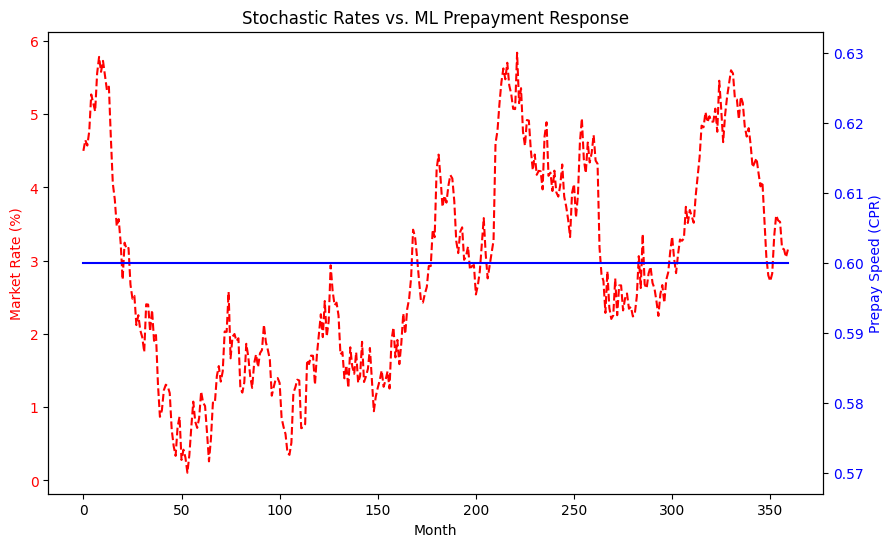

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import joblib
import sys

# Suppress warnings
warnings.filterwarnings('ignore')

# =============================================================================
# MODULE 1: STOCHASTIC RATE MODEL (VASICEK)
# =============================================================================
class StochasticRateModel:
    """
    Industry Standard: Vasicek One-Factor Mean Reverting Model.
    Equation: dr(t) = kappa * (theta - r(t)) * dt + sigma * dW(t)
    """
    def __init__(self, kappa=0.15, theta=0.045, sigma=0.012):
        self.kappa = kappa  # Speed of mean reversion
        self.theta = theta  # Long-term mean interest rate (4.5%)
        self.sigma = sigma  # Volatility (1.2% annual)
        self.dt = 1/12      # Monthly time steps

    def generate_paths(self, n_months, n_sims=1, start_rate=0.045, shock_scenario=None):
        np.random.seed(42)
        rates = np.zeros((n_months, n_sims))
        rates[0, :] = start_rate
        
        # Adjust theta (mean) based on scenario
        target_mean = self.theta
        if shock_scenario == "rally":
            target_mean = 0.025 # Rates drifting down to 2.5%
        elif shock_scenario == "selloff":
            target_mean = 0.075 # Rates drifting up to 7.5%

        for t in range(1, n_months):
            # Previous rate
            r_prev = rates[t-1, :]
            
            # Brownian Motion (Random Shock)
            dW = np.random.normal(0, np.sqrt(self.dt), n_sims)
            
            # Vasicek Equation
            dr = self.kappa * (target_mean - r_prev) * self.dt + self.sigma * dW
            
            rates[t, :] = r_prev + dr
            
        # Ensure rates don't go negative (optional floor)
        return np.maximum(rates, 0.001)

# =============================================================================
# MODULE 2: UNIVERSAL MODEL LOADER (ML LOGIC)
# =============================================================================
class UniversalModel:
    def __init__(self, model_path, model_type):
        self.path = model_path
        self.type = model_type
        self.model = None
        self.strategy = "Unknown"
        
        # Backup Weights
        if self.type == "Prepay":
            self.backup_weights = {
                'RATE_INCENTIVE': 0.1511, 'BURNOUT_PROXY': -0.0902,
                'CREDIT_SCORE': 0.0001, 'ORIGINAL_LTV': -0.0009,
                'ORIGINAL_DEBT_TO_INCOME_RATIO': -0.0004
            }
            self.baseline = 0.06 
        elif self.type == "Default":
            self.backup_weights = {
                'SATO': 0.5538, 'HIGH_LTV_FLAG': 0.3920,
                'FICO_BUCKET': 0.0276, 'CREDIT_SCORE': -0.0020
            }
            self.baseline = 0.005 

        self._initialize()

    def _initialize(self):
        if os.path.exists(self.path):
            try:
                self.model = joblib.load(self.path)
                self.strategy = "Pickle Model"
                print(f"   [ML] Loaded {self.type} from {self.path}")
                return
            except: pass
        print(f"   [System] Using Hardcoded Weights for {self.type}.")
        self.strategy = "Hardcoded"

    def predict_multiplier(self, df):
        if self.strategy == "Pickle Model" and self.model:
            try: return self.model.predict_partial_hazard(df)
            except: pass 
        
        log_hazard = 0.0
        for feat, weight in self.backup_weights.items():
            if feat in df.columns: log_hazard += df[feat] * weight
        return np.exp(log_hazard)

# =============================================================================
# MODULE 3: DATA MANAGER
# =============================================================================
class DataManager:
    def __init__(self, static_file, perf_file=None):
        self.static_file = static_file
        self.perf_file = perf_file
        self.raw_df = None
        self._load()

    def _load(self):
        if not os.path.exists(self.static_file):
            print("[Error] No Loan Tape found. Generating Mock Data...")
            self.raw_df = self._generate_mock(1000); return

        print(f"--- Loading Loan Tape: {self.static_file} ---")
        df = pd.read_csv(self.static_file, sep='|', low_memory=False)
        col_map = {'LOAN_SEQUENCE_NUMBER':'LOAN_ID', 'ORIGINAL_UPB':'ORIG_UPB',
                   'ORIGINAL_INTEREST_RATE':'NOTE_RATE', 'CREDIT_SCORE':'FICO',
                   'ORIGINAL_LOAN_TERM':'TERM', 'ORIGINAL_LTV':'LTV',
                   'PROPERTY_STATE':'STATE', 'ORIGINAL_DEBT_TO_INCOME_RATIO':'DTI'}
        df.rename(columns=col_map, inplace=True)
        
        df['NOTE_RATE'] = df['NOTE_RATE'].apply(lambda x: x/100 if x > 1 else x)
        for c in ['ORIG_UPB','FICO','LTV','DTI']:
            df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0)
            
        df['RATE_INCENTIVE'] = (df['NOTE_RATE']*100) - 4.0 
        df['SATO'] = df['RATE_INCENTIVE']
        df['FICO_BUCKET'] = np.select([df['FICO']>=750, df['FICO']>=700], [1, 2], default=3)
        df['HIGH_LTV_FLAG'] = (df['LTV'] > 80).astype(int)
        df['BURNOUT_PROXY'] = 0.0
        
        df['ORIGINAL_INTEREST_RATE'] = df['NOTE_RATE']; df['CREDIT_SCORE'] = df['FICO']
        df['ORIGINAL_LTV'] = df['LTV']; df['ORIGINAL_DEBT_TO_INCOME_RATIO'] = df['DTI']
        
        if self.perf_file and os.path.exists(self.perf_file):
            print(f"--- Seasoning using Performance Data ---")
            df_perf = pd.read_csv(self.perf_file, sep='|', usecols=['LOAN_SEQUENCE_NUMBER', 'CURRENT_ACTUAL_UPB'], low_memory=False)
            df_perf.rename(columns={'LOAN_SEQUENCE_NUMBER': 'LOAN_ID'}, inplace=True)
            latest = df_perf.groupby('LOAN_ID')['CURRENT_ACTUAL_UPB'].last().reset_index()
            df = pd.merge(df, latest, on='LOAN_ID', how='left')
            df['CURRENT_UPB'] = df['CURRENT_ACTUAL_UPB'].fillna(df['ORIG_UPB'])
            df = df[df['CURRENT_UPB'] > 0]
        else:
            df['CURRENT_UPB'] = df['ORIG_UPB']
        self.raw_df = df

    def _generate_mock(self, n):
        return pd.DataFrame({'ORIG_UPB': [300000]*n, 'CURRENT_UPB': [300000]*n})

    def get_pool(self):
        return self.raw_df[self.raw_df['CURRENT_UPB'] > 0].copy()

# =============================================================================
# MODULE 4: DYNAMIC SIMULATION
# =============================================================================
class SurveillanceEngine:
    def __init__(self, pool, prepay_model, default_model):
        self.pool = pool.copy()
        self.prepay = prepay_model
        self.default = default_model
        
    def run(self, rate_path):
        print("--- Running Stochastic Simulation ---")
        loans = self.pool.copy()
        loans['Active_Bal'] = loans['CURRENT_UPB']
        history = []
        
        BASE_CPR = 0.06; BASE_CDR = 0.005
        
        # Flatten rate_path if it's 2D
        if len(rate_path.shape) > 1: rate_path = rate_path.flatten()

        for t in range(len(rate_path)):
            if loans['Active_Bal'].sum() < 1000: break
            
            # 1. Stochastic Rate Update
            curr_rate = rate_path[t]
            
            # 2. Dynamic Incentive
            loans['RATE_INCENTIVE'] = (loans['NOTE_RATE'] - curr_rate) * 100 
            loans['BURNOUT_PROXY'] += np.where(loans['RATE_INCENTIVE'] > 0.5, 1.0, 0.0)
            
            # 3. ML Prediction
            cpr_mult = np.clip(self.prepay.predict_multiplier(loans), 0.1, 20.0)
            cdr_mult = np.clip(self.default.predict_multiplier(loans), 0.1, 10.0)
            
            cpr = np.clip(BASE_CPR * cpr_mult, 0.0, 1.0)
            cdr = np.clip(BASE_CDR * cdr_mult, 0.0, 1.0)
            
            smm = 1 - (1 - cpr)**(1/12)
            mdr = 1 - (1 - cdr)**(1/12)
            
            # 4. Cash Flows
            int_paid = loans['Active_Bal'] * (loans['NOTE_RATE']/12)
            r = loans['NOTE_RATE']/12
            denom = 1 - (1+r)**(-loans['TERM'])
            sched_pmt = loans['Active_Bal'] * r / np.where(denom==0, 1e-9, denom)
            sched_prin = (sched_pmt - int_paid).clip(lower=0)
            
            prepay = (loans['Active_Bal'] - sched_prin) * smm
            default = (loans['Active_Bal'] - sched_prin - prepay) * mdr
            loss = default * 0.35
            
            loans['Active_Bal'] -= (sched_prin + prepay + default)
            loans['Active_Bal'] = loans['Active_Bal'].clip(lower=0)
            
            history.append({
                'Period': t,
                'Market_Rate': curr_rate,
                'Interest': int_paid.sum(),
                'Principal': (sched_prin + prepay + default - loss).sum(),
                'Loss': loss.sum(),
                'CPR': cpr.mean()
            })
            
        return pd.DataFrame(history)

# =============================================================================
# MODULE 5: STRUCTURING
# =============================================================================
class Tranche:
    def __init__(self, name, balance, coupon):
        self.name = name; self.balance = balance; self.orig = balance; self.coupon = coupon
        self.cfs = []

def run_waterfall(tranches, cfs):
    print("--- Structuring Deal ---")
    equity = tranches[-1]
    
    for row in cfs.itertuples():
        avail_int = row.Interest
        avail_prin = row.Principal
        
        for t in tranches[:-1]:
            pay = min(avail_int, t.balance * t.coupon/12) if t.balance > 0 else 0
            avail_int -= pay
            t.cfs.append(pay)
            
        for t in tranches[:-1]:
            pay = min(t.balance, avail_prin) if t.balance > 0 else 0
            t.balance -= pay
            avail_prin -= pay
            t.cfs[-1] += pay
            
        equity.cfs.append(avail_int + avail_prin)
    return tranches

# =============================================================================
# MAIN EXECUTION
# =============================================================================
def main():
    DATA_DIR = "/media/hansheng/cc7df9bc-e728-4b8d-a215-b64f31876acc/cdo-tee-mock/prepayment/data/Extracted_data/"
    STATIC = DATA_DIR + "combined_sampled_mortgages_2017_2020.csv"
    PERF = DATA_DIR + "combined_performance_history_2017_2020.csv"
    PREPAY_PKL = DATA_DIR + "cox_prepayment_model.pkl"
    DEFAULT_PKL = DATA_DIR + "cox_default_model.pkl"
    
    # 1. Load Data
    data_mgr = DataManager(STATIC, PERF if os.path.exists(PERF) else None)
    
    # 2. Models
    print("\n[Initializing ML Models]")
    prepay = UniversalModel(PREPAY_PKL, "Prepay")
    default = UniversalModel(DEFAULT_PKL, "Default")
    
    # 3. Optimize
    pool = data_mgr.get_pool().sort_values('NOTE_RATE', ascending=False)
    if pool['CURRENT_UPB'].sum() > 500_000_000:
        pool['cumsum'] = pool['CURRENT_UPB'].cumsum()
        pool = pool[pool['cumsum'] <= 500_000_000].copy()
    start_bal = pool['CURRENT_UPB'].sum()
    print(f"\nDeal Balance: ${start_bal:,.0f}")
    
    # 4. Generate Stochastic Rates (Vasicek)
    # Scenario: "Rally" (Drift to 2.5%)
    print("\n[Generating Interest Rate Path: Vasicek Model]")
    vasicek = StochasticRateModel(kappa=0.15, theta=0.045, sigma=0.012)
    rates = vasicek.generate_paths(n_months=360, start_rate=0.045, shock_scenario="rally")
    
    # 5. Run Sim & Structure
    surv = SurveillanceEngine(pool, prepay, default)
    cfs = surv.run(rates)
    
    t_a = Tranche("Class A", start_bal*0.85, 0.030)
    t_b = Tranche("Class B", start_bal*0.10, 0.040)
    t_z = Tranche("Equity",  start_bal*0.05, 0.000)
    
    run_waterfall([t_a, t_b, t_z], cfs)
    
    # 6. Report
    profit = sum(t_z.cfs) - t_z.orig
    roi = profit / t_z.orig
    
    print("\n" + "="*40)
    print("FINAL REPORT (Stochastic Rates)")
    print("="*40)
    print(f"Scenario:       Vasicek Rally (Mean Reverting to 2.5%)")
    print(f"Equity Invest:  ${t_z.orig:,.0f}")
    print(f"Net Profit:     ${profit:,.0f}")
    print(f"ROI:            {roi:.2%}")
    print(f"Avg Speed:      {cfs['CPR'].mean():.2%}")
    
    # Dual Axis Plot: Rates vs CPR
    fig, ax1 = plt.subplots(figsize=(10,6))
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Market Rate (%)', color='red')
    ax1.plot(cfs['Market_Rate']*100, color='red', linestyle='--', label='Vasicek Rate')
    ax1.tick_params(axis='y', labelcolor='red')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Prepay Speed (CPR)', color='blue')
    ax2.plot(cfs['CPR']*100, color='blue', label='ML Predicted CPR')
    ax2.tick_params(axis='y', labelcolor='blue')
    
    plt.title("Stochastic Rates vs. ML Prepayment Response")
    
    plt.show()

if __name__ == "__main__":
    main()